## Categorical Distributions and Naive Bayes Classification
This notebook contains an implementation of Naive Bayes Clasification algorithm using both maximum likelihood estimation and Bayesian analysis. The algorithm is applied on the [Sentiment 140 dataset](https://www.kaggle.com/kazanova/sentiment140/download) from **kaggle.com**. Tweets are first filtered and vectorized before using them as inputs to the Naive Bayes classifier.

This notebook is based on a homework in the [CPSC 340 ML course](https://www.youtube.com/playlist?list=PLE6Wd9FR--Ecf_5nCbnSQMHqORpiChfJf) by Prof. Nando de Freitas:
* [Lecture Notes](https://www.cs.ubc.ca/~nando/340-2012/lectures/l19.pdf)
* [Homework](https://www.cs.ubc.ca/~nando/340-2012/lectures/homework5.pdf)

[Check my Github repository for similar introductory notebooks](https://github.com/YZouzou/ML-Topics-Intro)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from scipy.special import gamma
import scipy as sp

from ipywidgets import interact
import ipywidgets as widgets

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
# nltk.download('stopwords')
# nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import naive_bayes

### Beta Distribution
* The beta distribution is a distribution between 0 and 1 of a single variable. It is used as the prior of a binary categorical variable parameter.

$$ Beta(\alpha, \beta) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\cdot\Gamma(\beta)}\cdot
\theta^{\alpha-1} \cdot (1-\theta)^{\beta - 1} $$

In [2]:
def beta_dist(x, alpha, beta):
    return (gamma(alpha + beta) / (gamma(alpha) * gamma(beta))) * x**(alpha - 1) * (1 - x)**(beta - 1)
    

In [3]:
@interact (alpha = widgets.FloatSlider(min = 0.4, max = 5, step = 0.2, value = 0.4),
          beta = widgets.FloatSlider(min = 0.4, max = 5, step = 0.2, value = 0.4))
def plot_beta(alpha, beta):
    x = np.linspace(0, 1, 100)[1:-1]
    y = beta_dist(x, alpha, beta)
    plt.figure(figsize = (8, 6))
    plt.plot(x, y)
    plt.xlim(min(x), max(x))
    plt.ylim(0, 4)
    plt.fill_between(x, y, 0, alpha = 0.4)
    plt.show()

interactive(children=(FloatSlider(value=0.4, description='alpha', max=5.0, min=0.4, step=0.2), FloatSlider(val…

### Sentiment 140 Dataset
This dataset is from **kaggle.com** available [here](https://www.kaggle.com/kazanova/sentiment140).

#### Readings
* [Text Vectorization and Transformation Pipelines](https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html)

In [5]:
# The data must be downloded from the given link
# path = r"C:\Users\XXXX\Desktop\Machine Learning\Projects\Sentiment Analysis\training.1600000.processed.noemoticon.csv"
df = pd.read_csv(path, header = None, names = ['Target', 'ID', 'Date', 'Query', 'Username', 'Tweet'], encoding = 'latin-1')

In [6]:
df.head()

,Target,ID,Date,Query,Username,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.Target.value_counts()

4    800000
0    800000
Name: Target, dtype: int64

In [8]:
df.shape

(1600000, 6)

Creating a subset of the dataset with 4000 instances using `df.sample()`

In [9]:
all_data = df.sample(n = 4000).reset_index(drop = True)

In [10]:
print('Number of positive tweets:')
print(all_data[all_data['Target'] == 4].shape[0])
print('Number of negative tweets:')
print(all_data[all_data['Target'] == 0].shape[0])

Number of positive tweets:
2026
Number of negative tweets:
1974


In [11]:
all_data.head()

,Target,ID,Date,Query,Username,Tweet
0,0,2054816432,Sat Jun 06 08:08:26 PDT 2009,NO_QUERY,astradancer,Im super tired and i did nothing
1,0,2234837329,Thu Jun 18 23:51:28 PDT 2009,NO_QUERY,sportkine,@cyclingdiva But as I was In Japan a few month...
2,4,2176990022,Mon Jun 15 05:12:45 PDT 2009,NO_QUERY,_LauraFee,@MissIngyO8 im already excited for the card.i...
3,4,1678390278,Sat May 02 06:33:03 PDT 2009,NO_QUERY,erkx,"@ThinkReferrals : Darn, could only pray for th..."
4,0,2014330679,Wed Jun 03 01:10:27 PDT 2009,NO_QUERY,katielynn1,doing boring school work looking forward to t...


### Preprocessing tweets

In [12]:
tweets = all_data['Tweet']

In [13]:
t1 = tweets.iloc[50]
t1

'WOW too darn hot to work outside! What was I thinking! The gardens can wait!!  '

In [14]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer(language = 'english') 

`filter_tweet` function removes punctuation marks, URLs, and *stop words* from the tweet and returns the *stems* of the remaining words.

**Stop words** are words such as and, it, those, etc. which have no indication of sentiment.

**Stemming** is the process of removing suffixes from words and returning the main part of a word, i.e., **stem**. [Read more](https://www.geeksforgeeks.org/introduction-to-stemming)

Using this process, we reduce the dimensionality of the feature vector by reducing the vocabulary count.

In [15]:
def filter_tweet(txt):
    word_list = []
    m = re.compile(r'\@\S+|http\S+|[^(a-zA-Z\s)]+')
    re_filtered_txt = re.sub(m, '', txt).lower()
    for word in re_filtered_txt.split():
        if word not in stop_words:
            word_list.append(stemmer.stem(word))
    return ' '.join(set(word_list))

In [16]:
filter_tweet(t1)

'darn work hot wait garden think outsid wow'

In [17]:
all_data['filtered_tweet'] = all_data['Tweet'].apply(filter_tweet)

Some tweets are transformed into empty strings after filtering

In [18]:
null_index = all_data[all_data['filtered_tweet'] == ''].index
all_data.loc[null_index].head()

,Target,ID,Date,Query,Username,Tweet,filtered_tweet
54,4,1983452282,Sun May 31 13:10:59 PDT 2009,NO_QUERY,jesssicababesss,@beckinelson,
248,4,1882619809,Fri May 22 07:11:42 PDT 2009,NO_QUERY,Olivia_exists,@wearempires,
276,4,2059914368,Sat Jun 06 17:53:34 PDT 2009,NO_QUERY,JaylaStarr,@eunice007,
342,4,2052465846,Sat Jun 06 00:49:32 PDT 2009,NO_QUERY,lesley007,@tb78 I can!!,
606,4,1979633500,Sun May 31 03:53:02 PDT 2009,NO_QUERY,roobies,@chanikin YOU CAN DO IT,


In [19]:
all_data = all_data.drop(index = null_index).reset_index(drop = True)

In [20]:
target = all_data['Target'].apply(lambda x: 1 if x == 4 else 0)

In [21]:
df = pd.DataFrame({'tweet': all_data['Tweet'], 'target': target})

### `CountVectorizer()`
* This implementation from scikit-learn transforms a list of documents into a vectorized feature space.
* The input (in this case) is all the filtered tweets.
* The output is a sparse matrix with a number of columns equal to the vocabulary of the tweets and rows equal to the number of tweets.
* If `binary` is set to `True`, the vector will contain 1 values for words that appear instead of the number of occurences of that word, i.e. words are not counted in this case.
* [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [22]:
X = df['tweet']
y = df['target'].to_numpy()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [24]:
vectorizer = CountVectorizer(binary = True)
vectorizer.fit(X_train.apply(filter_tweet))

X_train = vectorizer.transform(X_train.apply(filter_tweet))
X_test = vectorizer.transform(X_test.apply(filter_tweet))
print('Vocabulary count: ', len(vectorizer.get_feature_names()))

Vocabulary count:  5518


`np.setdiff1d(ar1, ar2)` Return the unique values in ar1 that are not in ar2.

In [25]:
# Indexes of nonzero elements (positive tweets) in y_train
pos_index = np.nonzero(y_train)[0]

# Indexes of zero elements (negative tweets) in y_train
neg_index = np.setdiff1d(np.arange(0, y_train.shape[0]), pos_index)

In [26]:
Njc = np.array([np.asarray(np.sum(X_train[pos_index, :], axis = 0)).flatten(),
                np.asarray(np.sum(X_train[neg_index, :], axis = 0)).flatten()])

Nc = np.array([pos_index.shape[0], neg_index.shape[0]])

n = y_train.shape[0]

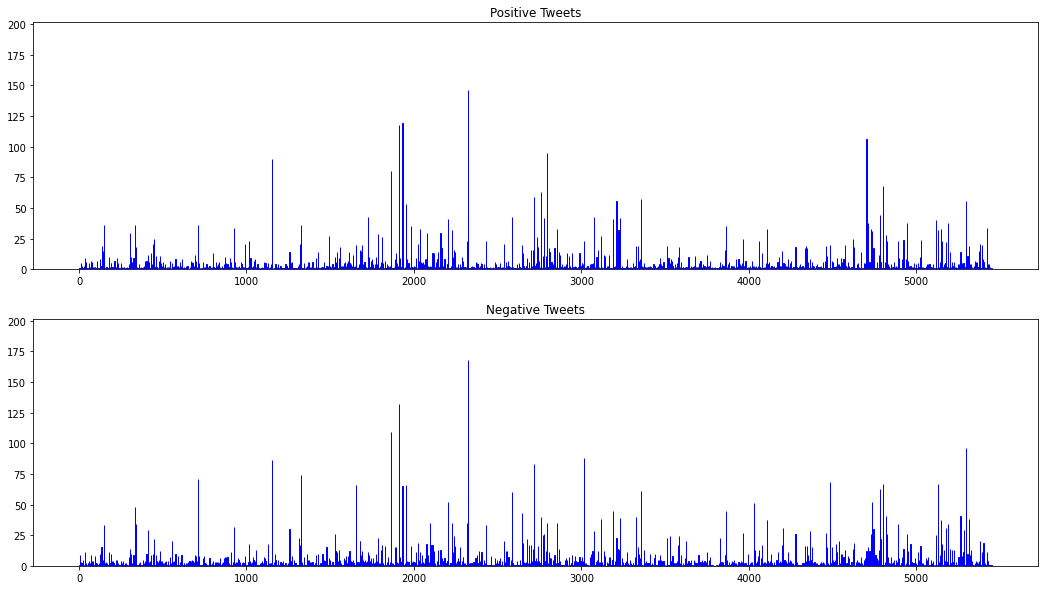

In [11]:
fig, axs = plt.subplots(2, 1, figsize = (18, 10))

ax1 = axs[0]
ax1.bar(x = np.arange(0, Njc.shape[1]), height = Njc[0, :], ec = 'blue')
ax1.set_title('Positive Tweets')
ax1.set_ylim(0, 1.2*Njc.max())

ax2 = axs[1]
ax2.bar(np.arange(0, Njc.shape[1]), Njc[1, :], ec = 'blue')
ax2.set_title('Negative Tweets')
ax2.set_ylim(0, 1.2*Njc.max())

plt.show()

### 1. Maximum Likelihood Estimation
Likelihood:
$$ p(y|X, \pi, \theta) \space \propto \space \prod_{i=1}^{n} \prod_{c=1}^{C} \pi_{c}^{I_c(y_i)} \cdot \prod_{j=1}^{d}\theta_{jc}^{I_c(y_i) \cdot I_1(x_{ij})} \cdot (1 - \theta_{jc})^{I_c(y_i) \cdot I_0(x_{ij})} $$

Assuming the following:
$$ N_c  =\sum_{i=1}^{n} I_c(y_i) $$
$$ N_{jc}  =\sum_{i=1}^{n} I_c(y_i) \cdot I_1(x_{ij}) $$

Where:
* n is the total number of data samples
* $N_c$ is the number of samples from class c
* $N_{jc}$ is the number of samples from class c that have the feature j (j word appears)

The likelihood becomes:
$$ p(y|D_{train}, \pi, \theta) \space \propto \space \prod_{c=1}^{C} \pi_{c}^{N_c} \cdot \prod_{j=1}^{d}\theta_{jc}^{N_{jc}} \cdot (1 - \theta_{jc})^{N_c - N_{jc}} $$
The maximum likelihood estimation of the parameters is:
$$ \pi_c = \frac{N_c}{n} $$

$$ \theta_{jc} = \frac{N_{jc}}{N_c} $$



Some words may not be available in one of the classes, and would consequently have a zero likelihood. This will cause any tweet containing such a word to have zero probability (-infinity in logspace). To avoid this problem, we add a constant number $\alpha$ to all word counts, so that the minimum word count would be $\alpha$ instead of zero. Then, we normalize to get likelihoods in the range [0, 1]. This technique is known as **Laplace smoothing**.

$$ \theta_{jc} = P(x_j = 1 \mid y = c \: ;\, \alpha) = \frac{ N_{jc} + \alpha}{N_{c} + \alpha n_j} $$
Where:
* $x_j$ is feature j (For example, the occurrence of a certain word (j) in this study)
* $\alpha$ is a smoothing parameter
* $n_j$ is the number of possible categories of feature $x_j$ (in this case 2, either the word appears or not)

### Making Predictions:
The probability of instance $x_i$ being from class c is:
$$ p(y = c|x_i, D_{train}, \pi, \theta) \space \propto \space \pi_{c} \cdot \prod_{j=1}^{d}\theta_{jc}^{I_1(x_{jc})} \cdot (1 - \theta_{jc})^{I_0(x_{jc})} $$

To classify $x_i$, we calculate the probabilities of it being from every possible class and choose the class with maximum probability.

The previous equation includes multiplying many probabilities (small numbers), which creates a risk of underflow. **Underflow** is when many small numbers are multiplied that the result will be too small and may be misinterpreted by computers. To avoid this scenario, we calculate probabilities in log space.

In order to get results in the range [0, 1] (after working in logspace) we use the **softmax function**:
$$ S(z_c) = \frac{e^{z_c}}{\sum_{i=1}^{C}e^{z_i}} $$
Where:
* $z_c$ is the **log** probability of $x_i$ being from class c
* $C$ is all the possible classes

$z$ in the previous equation would be the sum of small probabilities in the log space, which are large negative numbers. This will cause underflow to occur again when calculating the exponent of those negative numbers. To avoid this, we use the **log-sum-exp trick** explained below.

#### Log-Sum-Exp Trick:
Log-Sum-Exp function:
$$ log\sum^{n}_{i=1}e^{x_i} = a + log\sum^{n}_{i=1}e^{x_i - a}  $$
Where:
* $a$ is $max(x_i)$
    
Ex:
$$ log(e^{-150} + e^{-155}) = log(e^{-150}\cdot (e^0 + e^{-5})) = log(e^{0} + e^{-5}) - 150 $$

In the previous example, $e^{-5}$ and $e^{0}$ were computed instead of $e^{-155}$ and $e^{-150}$.

By taking the log of the softmax function:
\begin{align*} log \left(S(z_c) \right) &= log (e^{z_c}) - log (\sum_{i=1}^{C}e^{z_i})\\
                                        &= z_c - log (\sum_{i=1}^{C}e^{z_i})\\
                                 S(z_c) &= exp \left(z_c - log (\sum_{i=1}^{C}e^{z_i}) \right)           
\end{align*}

Where $log(\sum_{i=1}^{C}e^{z_i})$ is calculated using the log-sum-exp function.

### Implementation
Note that the following implementation uses the same vectorizer used on the training data to tokenize the tweets. Therefore, words not available in the vocabulary of the vectorizer will be ignored. As the probabilities are multiplied, an ignored word is equivalent to a word with probability of 1 of being in either of the two classes.

In [27]:
alpha = 0.5
nj = 2
theta = (Njc + alpha)/(Nc.reshape(-1, 1) + alpha*nj)

pi = Nc/n

In [28]:
def logsumexp(x):
    a = x.max()
    return a + np.log(np.sum(np.exp(x - a)))

def preprocess(tweet_series, vectorizer):
    return vectorizer.transform([filter_tweet(tweet_series)])

def predict(tweet, pi, theta, vectorizer):
    x = preprocess(tweet, vectorizer)
    L = np.log(pi)
    app_word_index = x.nonzero()[1]
    nonapp_word_index = np.setdiff1d(np.arange(0, x.shape[1]), app_word_index)
    p1 = np.log(theta[0, app_word_index]).sum() + np.log(1 - theta[0, nonapp_word_index]).sum()
    p0 = np.log(theta[1, app_word_index]).sum() + np.log(1 - theta[1, nonapp_word_index]).sum()
    
    L = L + np.array([p1, p0])
    
    p1 = np.exp(L[0] - logsumexp(L))
    p0 = np.exp(L[1] - logsumexp(L))
    
    return {'Positive': p1, 'Negative': p0}
    

In [30]:
pos_tweet = df.loc[df['target'] == 1, ['tweet']].sample()
tweet = pos_tweet.iloc[0, 0]
print(tweet)
predict(tweet, pi, theta, vectorizer)

MTV Movie Awards tonight!! In the meantime, I'm going to enjoy this warm, lazy Sunday I'm having 


{'Positive': 0.9999298174903076, 'Negative': 7.01825096941702e-05}

In [31]:
neg_tweet = df.loc[df['target'] == 0, ['tweet']].sample()
tweet = neg_tweet.iloc[0, 0]
print(tweet)
predict(tweet, pi, theta, vectorizer)

i always get really hungry this time of night 


{'Positive': 0.05780078396131046, 'Negative': 0.9421992160386904}

#### Predictions using a `Classifier` object

In [32]:
class CategoricalNBayesMLE:
    def __init__ (self, alpha = 1):
        self.params = ['alpha', 'logpi', 'logtheta']
        self.alpha = alpha
        
    def fit (self, X, y):
        alpha = self.alpha
        
        # Indexes of nonzero values (positive tweets) in y
        pos_index = np.nonzero(y)[0]
        
        # Indexes of zero values (negative tweets) in y
        neg_index = np.setdiff1d(np.arange(0, y.shape[0]), pos_index)
        
        Njc = np.array([np.asarray(np.sum(X[pos_index, :], axis = 0)).flatten(),
        np.asarray(np.sum(X[neg_index, :], axis = 0)).flatten()])

        Nc = np.array([pos_index.shape[0], neg_index.shape[0]]).reshape(-1, 1)

        n = y.shape[0]
        
        self.logpi = np.log(Nc / n)
        
        # Theta is an array of three dimensions
        # 1st dim: The possible categories of the target y (C=2)
        # 2nd dim: The possible categories of each feature in X ({0, 1}, i.e. dim = 2)
        # 3rd dim: The number of features in X (d)
        theta = np.zeros((Nc.shape[0], Njc.shape[0], Njc.shape[1]))
        
        theta[:, 0, :] = (Njc + alpha)/(Nc + alpha*2)
        theta[:, 1, :] = (Nc - Njc + alpha)/(Nc + alpha*2)
        
        self.logtheta = np.log(theta)
     
    # X should be a n*d vector of binary values
    def predict (self, X):
        
        result = np.zeros(X.shape[0])
        
        logtheta = self.logtheta
        
        for i, x in enumerate(X):
            
            L = self.logpi
            
            # Index of words appearing in the tweet (1s)
            app_word_index = x.nonzero()[1]

            # Index of words not appearing in the tweet (0s)
            nonapp_word_index = np.setdiff1d(np.arange(0, x.shape[0]), app_word_index)

            # p1 is the sum of log likelihoods assuming the tweet is positive
            p1 = logtheta[0, 0, app_word_index].sum() + logtheta[0, 1, nonapp_word_index].sum()

            # p0 is the sum of log likelihoods assuming the tweet is negative
            p0 = logtheta[1, 0, app_word_index].sum() + logtheta[1, 1, nonapp_word_index].sum()

            # Adding the log prior (pi_c)
            L = L + np.array([p1, p0]).reshape(-1, 1)

            # Applying the softmax function with log-sum-exp trick
            p1 = np.exp(L[0] - logsumexp(L))
            p0 = np.exp(L[1] - logsumexp(L))

            result[i] = 1 if p1>p0 else 0
        
        return result
    
    def save_params (self, fname):
        params = dict ([(p , getattr (self , p )) for p in self . params ])
        np . savez ( fname , ** params )
        
    def load_params ( self , fname ):
        params = np . load ( fname )
        for name in self . params :
            setattr ( self , name , params [ name ])


In [33]:
classifier = CategoricalNBayesMLE(alpha = 1)
classifier.fit(X_train, y_train)
y_hat = classifier.predict(X_test)
(y_hat == y_test).sum() / y_hat.shape[0]

0.7048192771084337

Positive tweets

In [34]:
x = df.loc[df['target'] == 1,'tweet'].sample().iloc[0]
print(x)
x = preprocess(x, vectorizer)
classifier.predict(np.array([x]))

Thinking of what I should do in Vegas??? Any good ideas or places that are a most see!?? 


array([1.])

Negative tweets


In [35]:
x = df.loc[df['target'] == 0,'tweet'].sample().iloc[0]
print(x)
x = preprocess(x, vectorizer)
classifier.predict(np.array([x]))

@FHTP What happened? That's horrible! 


array([0.])

### 2. Bayesian Analysis
We apply a Dirichlet prior on the parameter $\pi$ and a Beta distribution on $\theta$, to conform with the distributions in the likelihood. (In this study, the target, y, has only two possible classes so we could have chosen a Bernoulli and Beta distribution for the likelihood and prior, respectively)

$\pi$ prior:
$$ p(\pi_c) \propto \prod_{c=1}^{C} \pi_c^{\beta_c - 1} $$

$\theta$ prior:
$$ p(\theta_{jc}) \propto \theta_{jc}^{\gamma_1 - 1} \cdot (1-\theta_{jc})^{\gamma_2 - 1} $$
**Note:** There are $d\cdot C$ priors for X features, where $d$ is the number of features of X and $C$ the number of target classes. Meaning that each feature in each class has a Beta prior.

Multiplying the prior with the likelihood we get:

$$ p(\pi, \theta| X, y) = p(\pi, \theta| X) \cdot p(y|X, \pi, \theta) $$

$\pi$ and $\theta$ are independent:
$$ p(\pi, \theta) = p(\pi) \cdot p(\theta) $$

$$ p(\pi, \theta| X, y) \space \propto \space \prod_{c=1}^{C} \pi_{c}^{N_c + \beta_c -1} \cdot \prod_{j=1}^{d}\theta_{jc}^{N_{jc} + \gamma_1 - 1} \cdot (1 - \theta_{jc})^{\gamma_2 + N_c - N_{jc} - 1} $$

The posterior is a Dirichlet with parameters:
* For $\pi$:
$$ \beta_c' = N_c + \beta_c $$

* For $\theta$:
\begin{align*}
\gamma_1' &= \gamma_1 + N_{jc}\\
\gamma_2' &= \gamma_2 + N_{c} - N_{jc}
\end{align*}

Using these parameters we get a distribution for each $\pi$ and $\theta$, from which we can choose the desired value (mean, mode, etc.)

**Note:** Dirichlet distribution is a generalization of the Beta distribution for cases with more than two categories. Therefore, a Beta distribution is also a Dirichlet.

[Dirichlet Distribution - Wikipedia](https://en.wikipedia.org/wiki/Dirichlet_distribution)

[Beta Distribution - Wikipedia](https://en.wikipedia.org/wiki/Beta_distribution)

### Implementation
In the following implementation it is assumed that all X features have each the same Dirichlet parameters.


#### class `CategoricalNBayesBayesian(beta, gamma)`:
* `beta` is a list of Dirichlet distribution parameters for $\pi$'s prior ($\beta_i > 0$)
* `gamma` is a list of Dirichlet distribution parameters for $\theta$'s prior ($\gamma_i > 0$)

In [36]:
class CategoricalNBayesBayesian:
    def __init__ (self, beta, gamma):
        self.params = ['logpi', 'logtheta', 'beta', 'gamma']
        self.beta = beta
        self.gamma = gamma
        
    def fit (self, X, y):
        
        # Indexes of nonzero values (positive tweets) in y
        pos_index = np.nonzero(y)[0]
        
        # Indexes of zero values (negative tweets) in y
        neg_index = np.setdiff1d(np.arange(0, y.shape[0]), pos_index)
        
        Njc = np.array([np.asarray(np.sum(X[pos_index, :], axis = 0)).flatten(),
        np.asarray(np.sum(X[neg_index, :], axis = 0)).flatten()])

        Nc = np.array([pos_index.shape[0], neg_index.shape[0]]).reshape(-1, 1)

        n = y.shape[0]
        
        beta = np.array(self.beta).reshape(-1, 1)
        gamma = np.array(self.gamma).reshape(-1, 1)
        
        # Theta is an array of three dimensions
        # 1st dim: The possible categories of the target y (C=2)
        # 2nd dim: The possible categories of each feature in X ({0, 1}, i.e. dim = 2)
        # 3rd dim: The number of features in X (d)
        theta = np.zeros((Nc.shape[0], Njc.shape[0], Njc.shape[1]))
        
        self.logpi = np.log((Nc + beta) / (beta.sum() + n))
        theta[:, 0, :] = (Njc + gamma[0]) / (gamma.sum() + Nc)
        theta[:, 1, :] = (Nc - Njc + gamma[1]) / (gamma.sum() + Nc)
        self.logtheta = np.log(theta)
     
    # X should be a nxd vector of binary values
    def predict (self, X):
        
        result = np.zeros(X.shape[0])
        
        logtheta = self.logtheta
        
        for i, x in enumerate(X):
            
            L = self.logpi
            
            # Index of words appearing in the tweet (1s)
            app_word_index = x.nonzero()[1]

            # Index of words not appearing in the tweet (0s)
            nonapp_word_index = np.setdiff1d(np.arange(0, x.shape[0]), app_word_index)

            # p1 is the sum of log likelihoods assuming the tweet is positive
            p1 = logtheta[0, 0, app_word_index].sum() + logtheta[0, 1, nonapp_word_index].sum()

            # p0 is the sum of log likelihoods assuming the tweet is negative
            p0 = logtheta[1, 0, app_word_index].sum() + logtheta[1, 1, nonapp_word_index].sum()

            # Adding the log prior (pi_c)
            L = L + np.array([p1, p0]).reshape(-1, 1)

            # Applying the softmax function with log-sum-exp trick
            p1 = np.exp(L[0] - logsumexp(L))
            p0 = np.exp(L[1] - logsumexp(L))

            result[i] = 1 if p1>p0 else 0
        
        return result
    
    def save_params (self, fname):
        params = dict ([(p , getattr (self , p )) for p in self . params ])
        np . savez ( fname , ** params )
        
    def load_params ( self , fname ):
        params = np . load ( fname )
        for name in self . params :
            setattr ( self , name , params [ name ])


In [37]:
bayes_classifier = CategoricalNBayesBayesian(beta = [1, 1], gamma = [1, 1])
bayes_classifier.fit(X_train, y_train)
y_hat = bayes_classifier.predict(X_test)
(y_hat == y_test).sum() / y_test.shape[0]

0.7048192771084337

### Scikit-learn Implementation

In [38]:
sk_classifier = naive_bayes.BernoulliNB(alpha = 1)
sk_classifier.fit(X_train, y_train)
y_hat = sk_classifier.predict(X_test)
(y_hat == y_test).sum() / y_test.shape[0]

0.7188755020080321

### To do:
* Try applying it on a case of multiple categories (not binary)
* Try applying a Gaussian Naive Bayes
* Try addressing the problem of words not available in training data